In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, LearningRateScheduler, CSVLogger
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
import albumentations as A
from matplotlib import pyplot as plt

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Detect and initialize the GPUs
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Constants
IMAGE_SIZE = (128, 128, 3)
BATCH_SIZE = 32
EPOCHS = 150 
ORIGINAL_IMAGES_DIR = '/kaggle/input/drone-landing-dataset/Dataset/original_images/'
RGB_MASKS_DIR = '/kaggle/input/drone-landing-dataset/Dataset/RGB_color_image_masks/'
LABEL_IMAGES_DIR = '/kaggle/input/drone-landing-dataset/Dataset/label_images_semantic/'
CLASS_DICT_PATH = '/kaggle/input/drone-landing-dataset/Dataset/class_dict_seg.csv'

# Read class dictionary
class_dict_df = pd.read_csv(CLASS_DICT_PATH, index_col=False, skipinitialspace=True)
label_names = list(class_dict_df.name)
label_codes = [(r, g, b) for r, g, b in zip(class_dict_df.r, class_dict_df.g, class_dict_df.b)]

# Create colormap for encoding masks
id2code = {i: code for i, code in enumerate(label_codes)}
code2id = {code: i for i, code in enumerate(label_codes)}

# Split the dataset into train, validation, and test sets
all_image_paths = sorted([os.path.join(ORIGINAL_IMAGES_DIR, img) for img in os.listdir(ORIGINAL_IMAGES_DIR)])
all_mask_paths = sorted([os.path.join(RGB_MASKS_DIR, img) for img in os.listdir(RGB_MASKS_DIR)])

train_images, test_images, train_masks, test_masks = train_test_split(all_image_paths, all_mask_paths, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Data augmentation
transform = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.CLAHE(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2)
])

def load_image_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    return image, mask

def preprocess(image, mask):
    transformed = transform(image=image, mask=mask)
    image = transformed['image'] / 255.0  # Normalize the image
    mask = rgb_to_onehot(transformed['mask'], code2id).astype(np.float32)
    return image, mask

def rgb_to_onehot(rgb_image, colormap):
    num_classes = len(colormap)
    shape = rgb_image.shape[:2] + (num_classes,)
    encoded_image = np.zeros(shape, dtype=np.float32)
    for i, cls in enumerate(colormap):
        match = np.all(rgb_image == cls, axis=-1)
        encoded_image[match, i] = 1
    return encoded_image

def generator(image_paths, mask_paths, batch_size):
    while True:
        x_batch = []
        y_batch = []
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            image_batch = image_paths[start:end]
            mask_batch = mask_paths[start:end]

            for img_path, mask_path in zip(image_batch, mask_batch):
                image, mask = load_image_mask(img_path, mask_path)
                image, mask = preprocess(image, mask)
                x_batch.append(image)
                y_batch.append(mask)
            
            yield np.array(x_batch), np.array(y_batch)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

Number of devices: 2


In [ ]:
def unet(input_shape, num_classes, learning_rate):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freezing the pretrained layers

    # Contracting Path
    c1 = base_model.get_layer('block1a_activation').output
    c2 = base_model.get_layer('block2b_add').output
    c3 = base_model.get_layer('block3b_add').output
    c4 = base_model.get_layer('block4c_add').output
    c5 = base_model.get_layer('top_activation').output

    # Expansive Path
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    u10 = UpSampling2D(size=(2, 2))(c9)
    u10 = concatenate([u10, base_model.input])
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = BatchNormalization()(c10)
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
    c10 = BatchNormalization()(c10)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c10)

    model = Model(inputs=[base_model.input], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', 
                  metrics=[MeanIoU(num_classes=num_classes), dice_coefficient])

    return model

class DisplayCallback(Callback):
    def __init__(self, val_images, val_masks, num_images=5):
        super().__init__()
        self.val_images = val_images
        self.val_masks = val_masks
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_images[:self.num_images])
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, 5 * self.num_images))
        for i in range(self.num_images):
            axes[i, 0].imshow(self.val_images[i])
            axes[i, 0].set_title('Image')
            axes[i, 1].imshow(np.argmax(self.val_masks[i], axis=-1))
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow(np.argmax(preds[i], axis=-1))
            axes[i, 2].set_title('Prediction')
        plt.tight_layout()
        plt.show()

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

# Load the saved model
model = load_model('/kaggle/working/unet_model.keras', custom_objects={'dice_coefficient': dice_coefficient, 'MeanIoU': MeanIoU})

# Learning rate scheduler to start from the current epoch
current_epoch = 34
exponential_decay_fn = exponential_decay(0.0001, 150)
lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

# Create generators
train_gen = generator(train_images, train_masks, BATCH_SIZE)
val_gen = generator(val_images, val_masks, BATCH_SIZE)

# Load validation images and masks for display callback
val_images_display, val_masks_display = next(val_gen)

# Calculate steps per epoch
steps_per_epoch = len(train_images) // BATCH_SIZE
validation_steps = len(val_images) // BATCH_SIZE

# Callbacks
checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
csvlogger = CSVLogger(filename="model_training_csv.log", separator=",", append=True)
display_cb = DisplayCallback(val_images_display, val_masks_display)
callbacks = [checkpoint, reduce_lr, csvlogger, display_cb, lr_scheduler]

# Continue training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    initial_epoch=current_epoch,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot loss, IoU, and Dice over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mean_io_u'], label='Training IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
plt.title('IoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['dice_coefficient'], label='Training Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.savefig('metrics_plot.png')
plt.show()

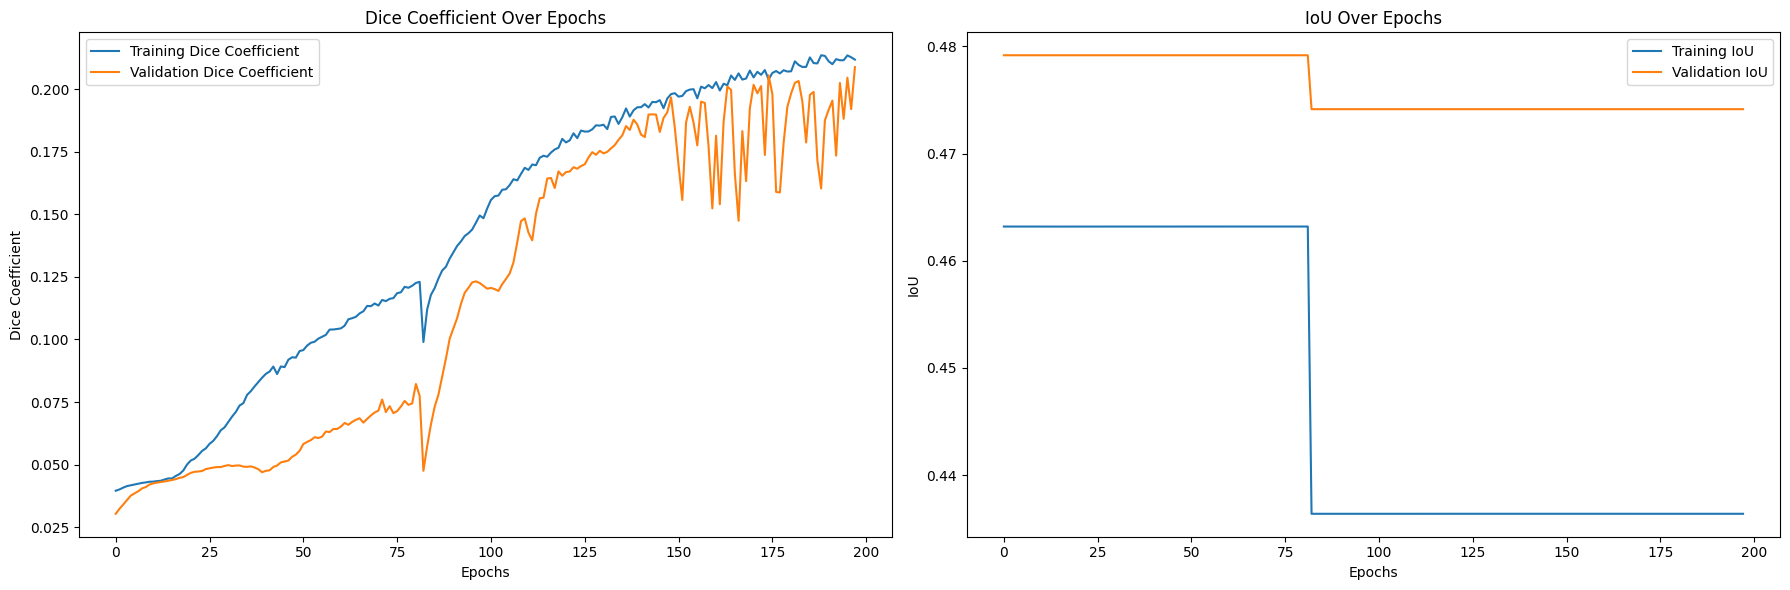

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

history_df = pd.read_csv("model_training_csv.log")

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Dice Coefficient over epochs
axes[0].plot(history_df['dice_coefficient'], label='Training Dice Coefficient')
axes[0].plot(history_df['val_dice_coefficient'], label='Validation Dice Coefficient')
axes[0].set_title('Dice Coefficient Over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Dice Coefficient')
axes[0].legend()

# Plot IoU over epochs
axes[1].plot(history_df['mean_io_u_1'], label='Training IoU')
axes[1].plot(history_df['val_mean_io_u_1'], label='Validation IoU')
axes[1].set_title('IoU Over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IoU')
axes[1].legend()

plt.tight_layout()
plt.savefig('metrics_plot.png')
plt.show()


Available class names: ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image 0 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 11 12 13 14 15 16 19 20 21 23]
Image 0 - Center of landing zone: (41, 69)
Image 0 - Scaled center of landing zone: (1921, 2156)
Drawing X at: (1921, 2156)
Drawing X at: (1921, 2156)
Drawing X at: (1921, 2156)


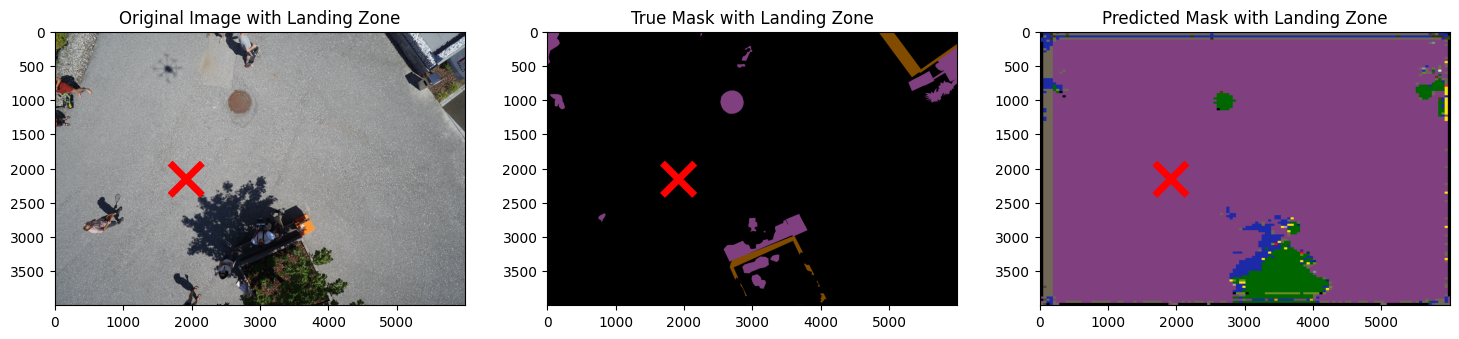

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 1 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 11 12 13 14 15 16 19 20 21 23]
Image 1 - Center of landing zone: (53, 51)
Image 1 - Scaled center of landing zone: (2484, 1593)
Drawing X at: (2484, 1593)
Drawing X at: (2484, 1593)
Drawing X at: (2484, 1593)


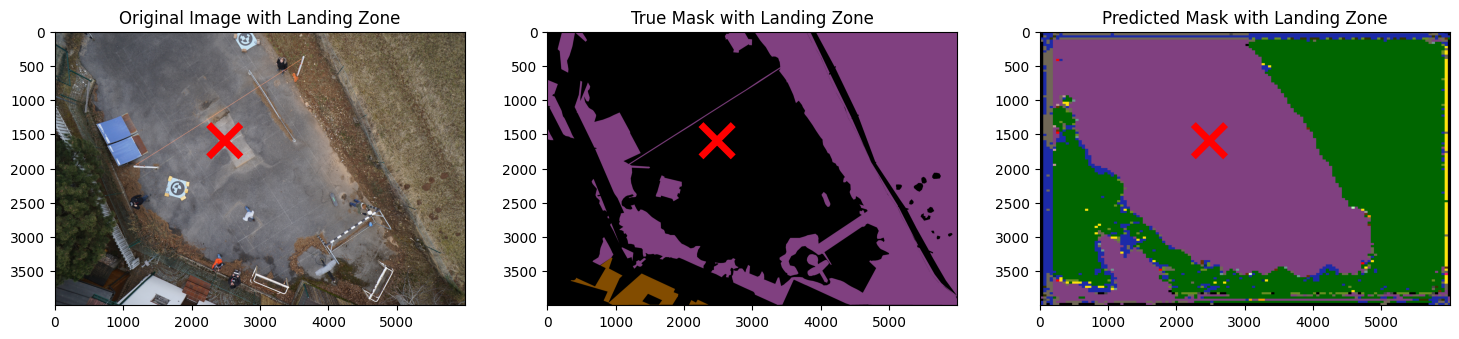

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 2 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23]
Image 2 - Center of landing zone: (None, None)
No valid landing zone found.
No valid landing zone found.
No valid landing zone found.


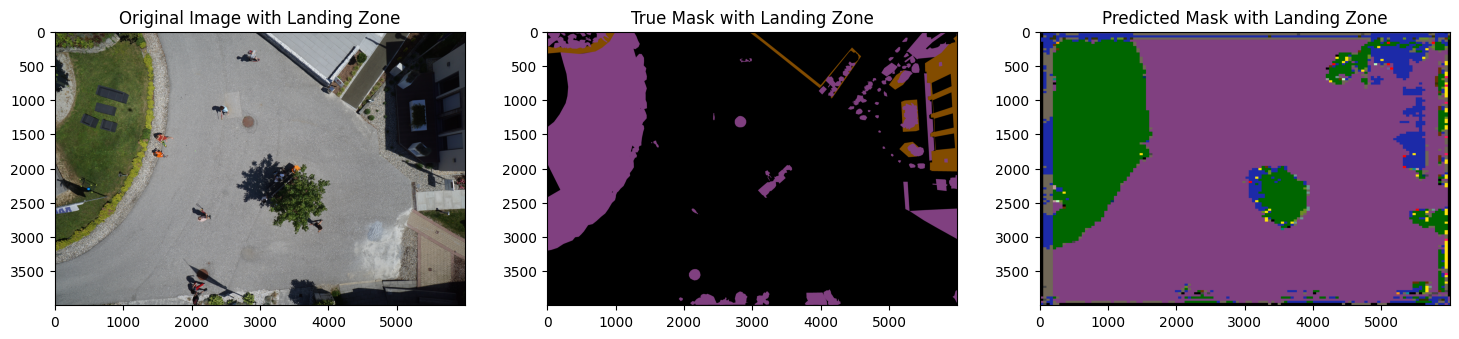

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 3 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 14 15 16 19 20 21 22 23]
Image 3 - Center of landing zone: (97, 48)
Image 3 - Scaled center of landing zone: (4546, 1500)
Drawing X at: (4546, 1500)
Drawing X at: (4546, 1500)
Drawing X at: (4546, 1500)


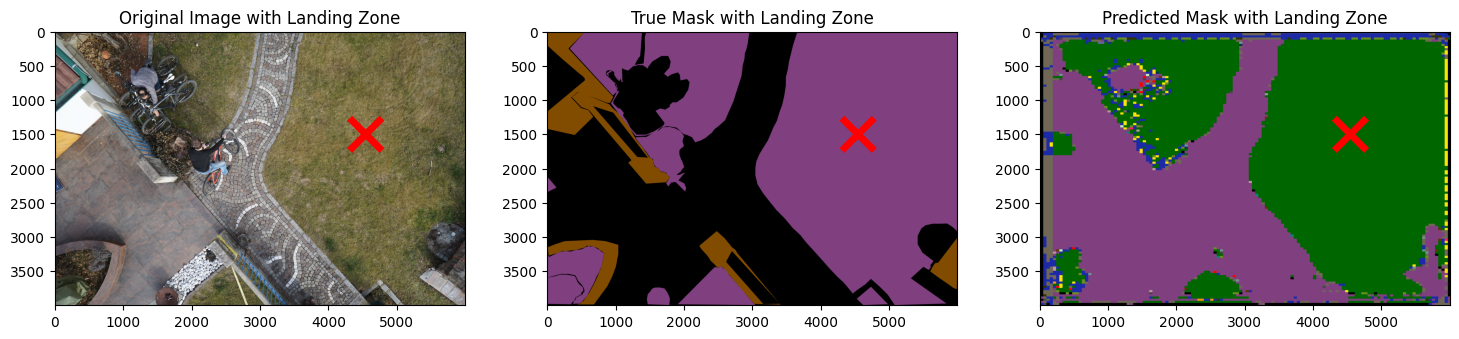

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 4 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 14 15 16 19 20 21 22 23]
Image 4 - Center of landing zone: (47, 87)
Image 4 - Scaled center of landing zone: (2203, 2718)
Drawing X at: (2203, 2718)
Drawing X at: (2203, 2718)
Drawing X at: (2203, 2718)


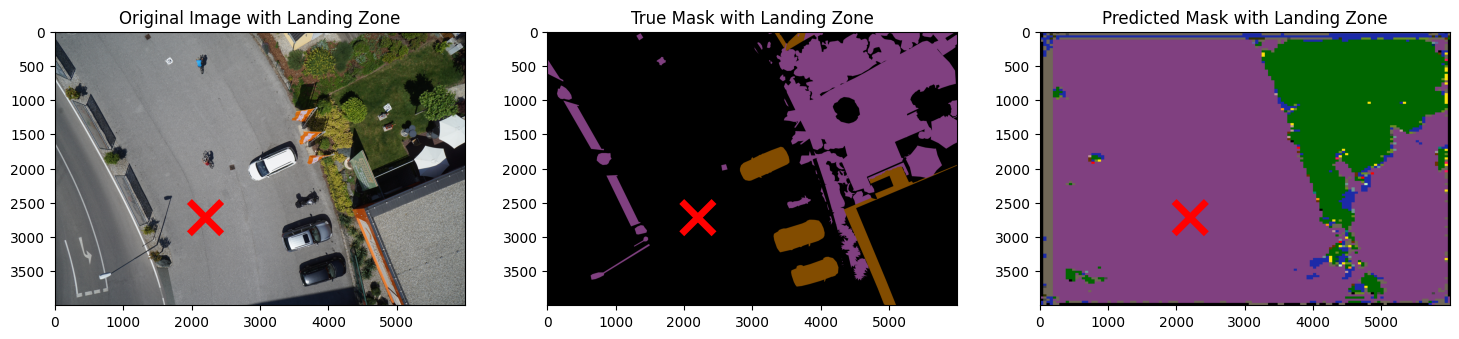

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 5 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23]
Image 5 - Center of landing zone: (56, 98)
Image 5 - Scaled center of landing zone: (2625, 3062)
Drawing X at: (2625, 3062)
Drawing X at: (2625, 3062)
Drawing X at: (2625, 3062)


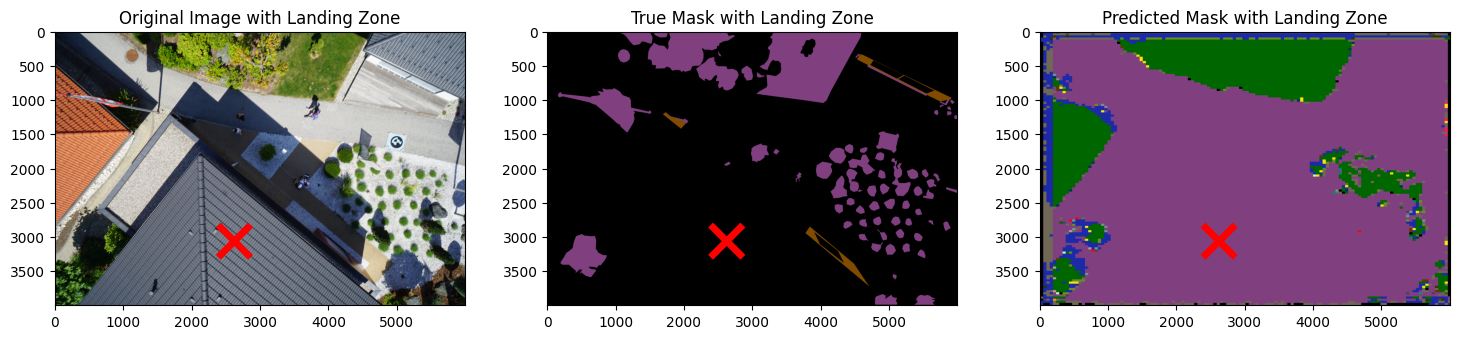

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 6 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 11 12 13 14 15 16 17 19 20 21 22 23]
Image 6 - Center of landing zone: (None, None)
No valid landing zone found.
No valid landing zone found.
No valid landing zone found.


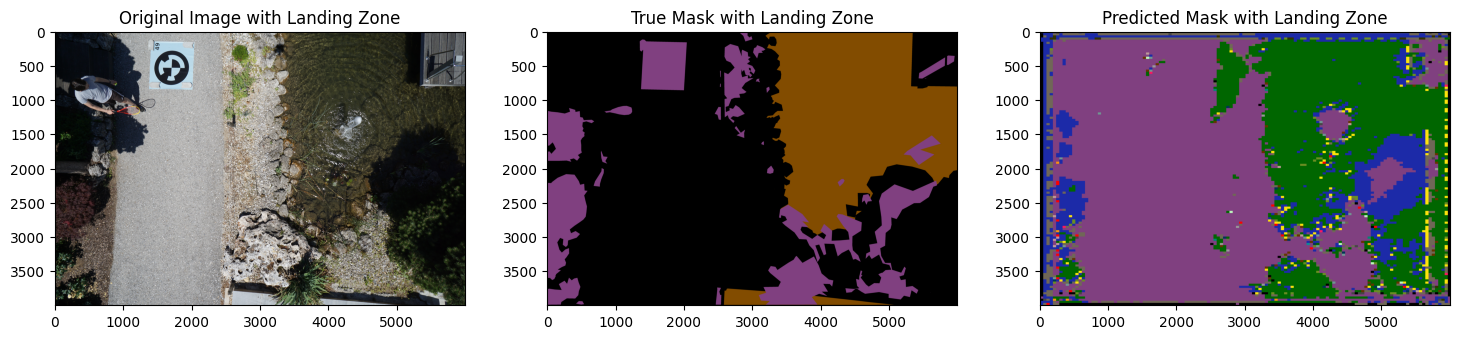

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 7 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 14 15 16 19 20 21 22 23]
Image 7 - Center of landing zone: (73, 83)
Image 7 - Scaled center of landing zone: (3421, 2593)
Drawing X at: (3421, 2593)
Drawing X at: (3421, 2593)
Drawing X at: (3421, 2593)


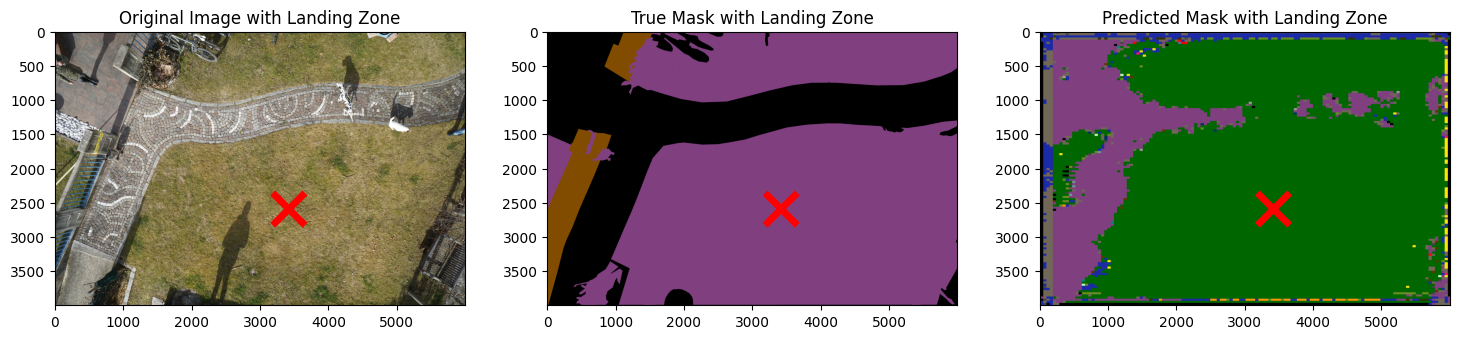

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image 8 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 15 16 19 20 21 23]
Image 8 - Center of landing zone: (53, 60)
Image 8 - Scaled center of landing zone: (2484, 1875)
Drawing X at: (2484, 1875)
Drawing X at: (2484, 1875)
Drawing X at: (2484, 1875)


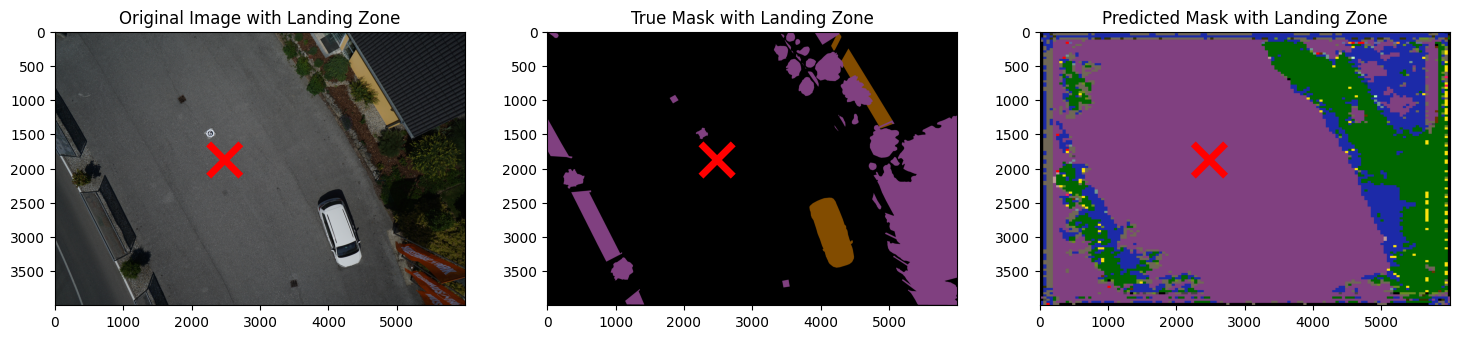

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 9 - Unique values in predicted mask: [ 0  1  3  4  5  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23]
Image 9 - Center of landing zone: (4, 48)
Image 9 - Scaled center of landing zone: (187, 1500)
Drawing X at: (187, 1500)
Drawing X at: (187, 1500)
Drawing X at: (187, 1500)


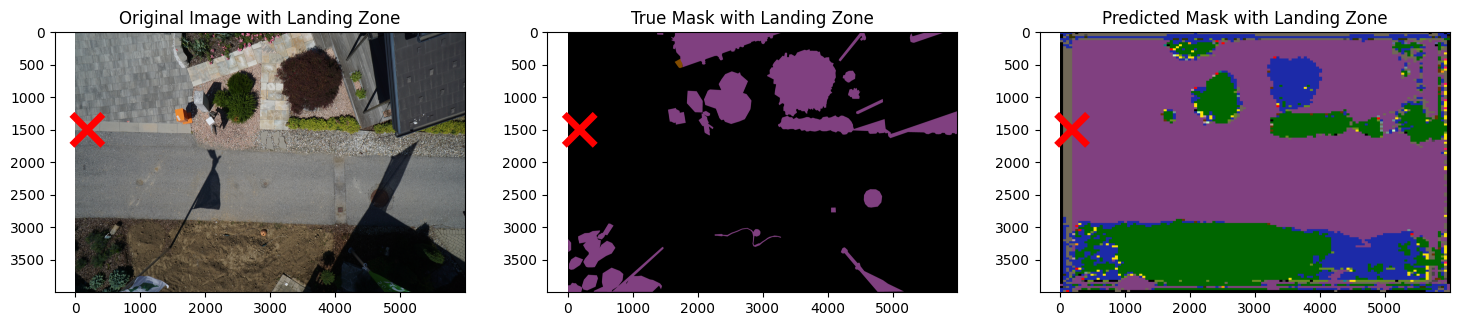

In [6]:
import numpy as np
import cv2
import pandas as pd
from skimage.measure import label, regionprops
from skimage.morphology import dilation, square
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import os

# Constants and paths
CLASS_DICT_PATH = '/kaggle/input/drone-landing-dataset/Dataset/class_dict_seg.csv'
MODEL_PATH = '/kaggle/working/unet_model.keras'
IMAGE_SIZE = (128, 128, 3)
ORIGINAL_IMAGES_DIR = '/kaggle/input/drone-landing-dataset/Dataset/original_images/'
RGB_MASKS_DIR = '/kaggle/input/drone-landing-dataset/Dataset/RGB_color_image_masks/'  # Assuming RGB masks are here

# Read class dictionary
class_dict_df = pd.read_csv(CLASS_DICT_PATH, index_col=False, skipinitialspace=True)
label_names = list(class_dict_df.name)
label_codes = [(r, g, b) for r, g, b in zip(class_dict_df.r, class_dict_df.g, class_dict_df.b)]

# Print the class names to check the available class names
print("Available class names:", label_names)

# Define safe area and obstacle classes
safe_area_classes = ['grass', 'paved-area', 'dirt', 'gravel']
obstacle_classes = ['tree', 'bald-tree', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'ar-marker', 'obstacle', 'conflicting']

safe_area_labels = [label_names.index(cls) for cls in safe_area_classes]
obstacle_labels = [label_names.index(cls) for cls in obstacle_classes]

def find_landing_zone(pred_mask, min_distance_from_obstacles=50):
    # Create a mask for all safe areas
    safe_mask = np.isin(pred_mask, safe_area_labels).astype(np.uint8)
    obstacle_mask = np.isin(pred_mask, obstacle_labels).astype(np.uint8)
    
    # Dilate the obstacle mask to create a buffer zone
    buffer_zone = dilation(obstacle_mask, square(min_distance_from_obstacles))
    
    # Exclude regions within the buffer zone from the safe mask
    safe_mask[buffer_zone == 1] = 0
    
    # Find connected components in the safe area
    labeled_mask = label(safe_mask)
    regions = regionprops(labeled_mask)
    
    if not regions:
        return None, None
    
    # Filter regions by size 
    min_region_size = 100
    regions = [region for region in regions if region.area >= min_region_size]
    
    if not regions:
        return None, None
    
    # Calculate distances from obstacles for each region
    def calculate_distance_from_obstacles(region):
        min_distance = float('inf')
        for coord in region.coords:
            y, x = coord
            for dy in range(-min_distance_from_obstacles, min_distance_from_obstacles + 1):
                for dx in range(-min_distance_from_obstacles, min_distance_from_obstacles + 1):
                    if (0 <= y + dy < pred_mask.shape[0]) and (0 <= x + dx < pred_mask.shape[1]):
                        if pred_mask[y + dy, x + dx] in obstacle_labels:
                            distance = np.sqrt(dx**2 + dy**2)
                            if distance < min_distance:
                                min_distance = distance
        return min_distance

    regions = [(region, calculate_distance_from_obstacles(region)) for region in regions]
    
    # Sort regions by distance from obstacles and size
    regions = sorted(regions, key=lambda x: (x[1], -x[0].area))
    
    # Select the best region
    best_region = regions[0][0]
    
    # Get the center of the best region
    center_y, center_x = best_region.centroid
    center_x, center_y = int(center_x), int(center_y)
    
    return center_x, center_y

def draw_x(ax, center_x, center_y, size=200, color='red', thickness=5):
    if center_x is None or center_y is None:
        print("No valid landing zone found.")
        return
    print(f"Drawing X at: ({center_x}, {center_y})")
    ax.plot([center_x - size, center_x + size], [center_y - size, center_y + size], color=color, linewidth=thickness)
    ax.plot([center_x + size, center_x - size], [center_y - size, center_y + size], color=color, linewidth=thickness)

def visualize_mask(mask, num_classes):
    # Convert the mask to a color image for better visualization
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(num_classes):
        color_mask[mask == i] = label_codes[i]
    return color_mask

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'dice_coefficient': dice_coefficient, 'MeanIoU': MeanIoU})

# Load some sample images and their true masks
original_images = []
true_masks = []
for img_name in sorted(os.listdir(ORIGINAL_IMAGES_DIR))[:10]:  # Load the first 10 images
    img_path = os.path.join(ORIGINAL_IMAGES_DIR, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_images.append(img)
    
    mask_path = os.path.join(RGB_MASKS_DIR, img_name.replace('.jpg', '.png'))  # Adjust mask file extension if necessary
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        true_masks.append(mask)
    else:
        true_masks.append(None)

#  Usage:
for i in range(len(original_images)):
    original_img = original_images[i]
    true_mask = true_masks[i]
    
    original_height, original_width = original_img.shape[:2]
    
    # Preprocess the image for prediction
    input_img = cv2.resize(original_img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
    input_img = input_img / 255.0
    input_img = np.expand_dims(input_img, axis=0)
    
    # Predict the segmentation mask
    pred_mask = model.predict(input_img)
    pred_mask = np.argmax(pred_mask[0], axis=-1)
    
    # Debug: Print the unique values in the predicted mask
    print(f"Image {i} - Unique values in predicted mask:", np.unique(pred_mask))
    
    # Get the center of the landing zone from the predicted mask
    center_x, center_y = find_landing_zone(pred_mask)
    print(f"Image {i} - Center of landing zone: ({center_x}, {center_y})")
    
    # Scale the coordinates back to the original image size
    if center_x is not None and center_y is not None:
        scale_x = original_width / IMAGE_SIZE[1]
        scale_y = original_height / IMAGE_SIZE[0]
        center_x = int(center_x * scale_x)
        center_y = int(center_y * scale_y)
        print(f"Image {i} - Scaled center of landing zone: ({center_x}, {center_y})")
    
    # Resize the masks to the original image size for visualization
    pred_with_x = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    if true_mask is not None:
        true_with_x = cv2.resize(np.argmax(true_mask, axis=-1), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    else:
        true_with_x = np.zeros_like(original_img[..., 0])
    
    # Visualize the masks as color images
    pred_color_mask = visualize_mask(pred_with_x, len(label_names))
    true_color_mask = visualize_mask(true_with_x, len(label_names))
    
    # Display the images
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original_img)
    draw_x(axes[0], center_x, center_y)
    axes[0].set_title('Original Image with Landing Zone')
    
    axes[1].imshow(true_color_mask)
    draw_x(axes[1], center_x, center_y)
    axes[1].set_title('True Mask with Landing Zone')
    
    axes[2].imshow(pred_color_mask)
    draw_x(axes[2], center_x, center_y)
    axes[2].set_title('Predicted Mask with Landing Zone')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


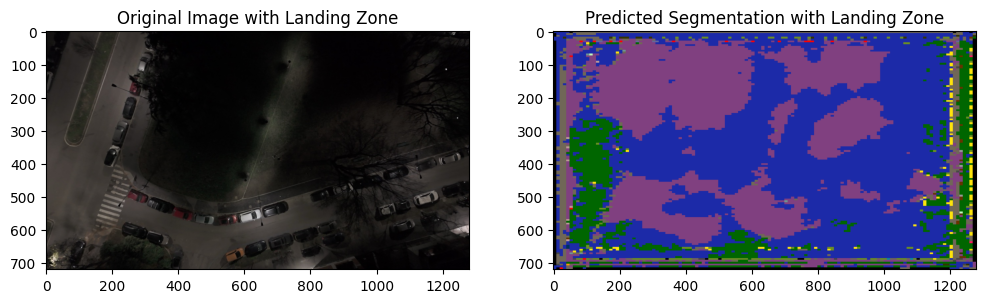

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


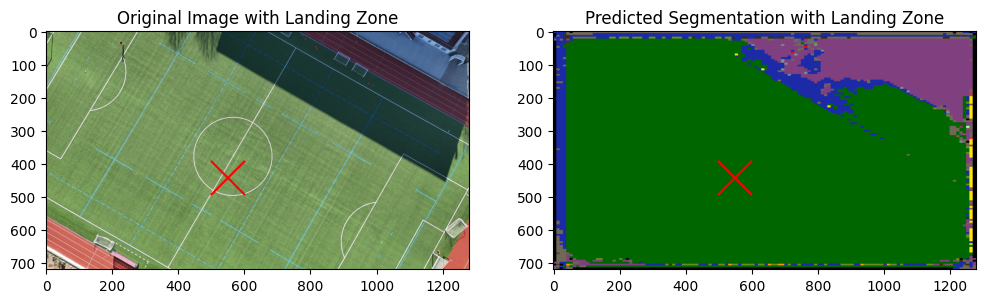

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


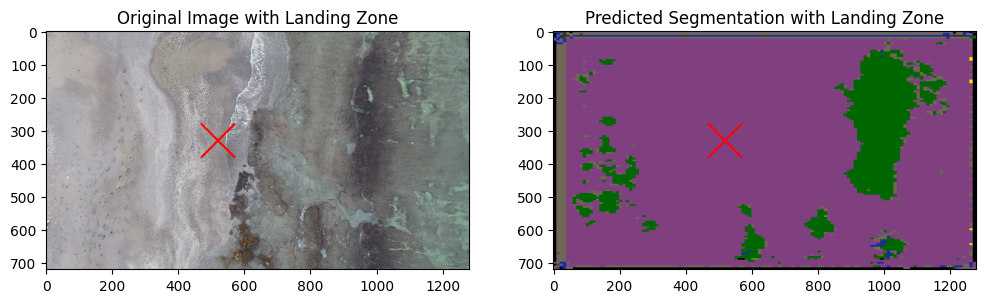

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


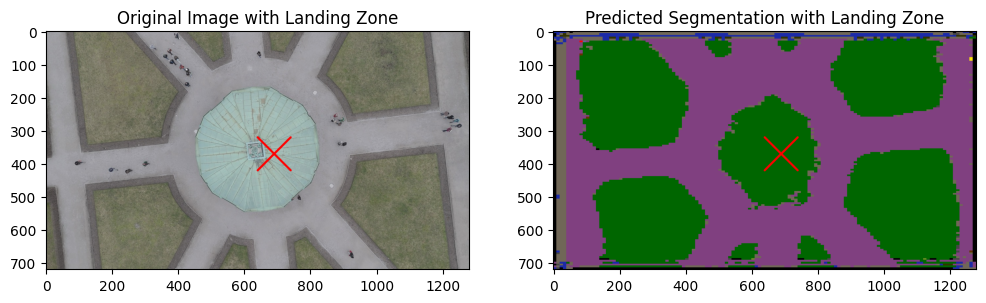

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


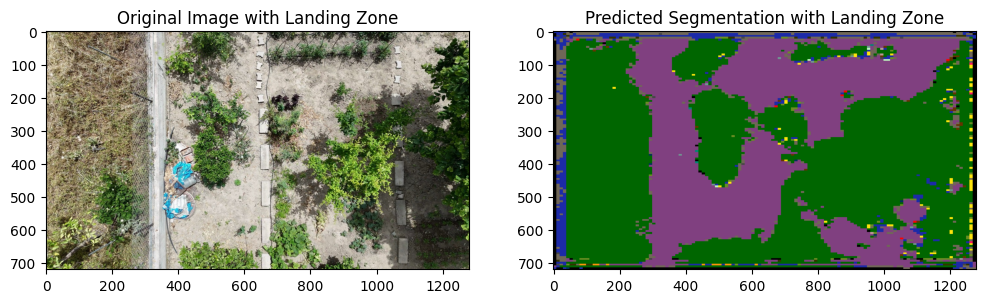

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


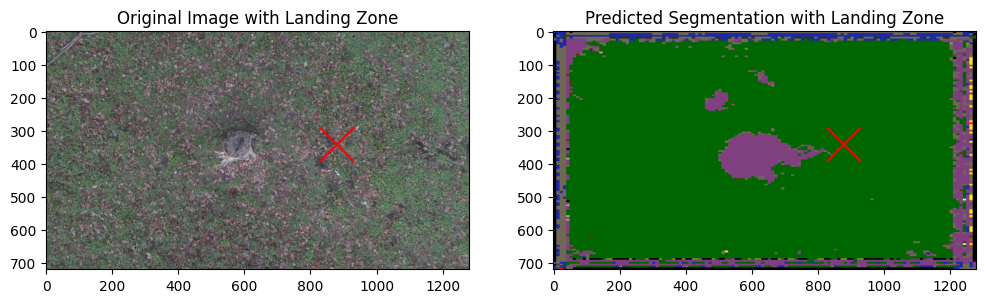

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


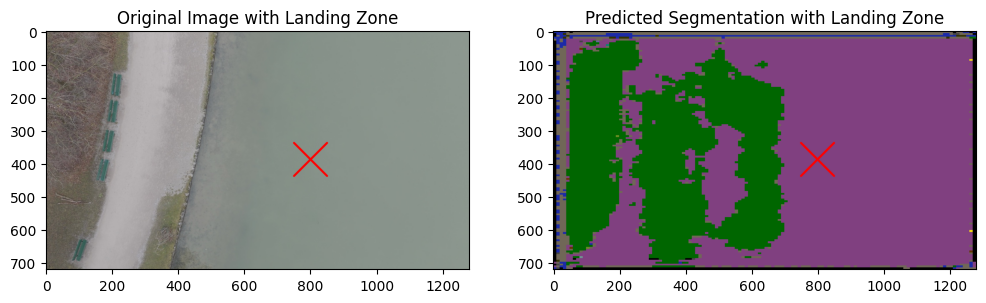

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


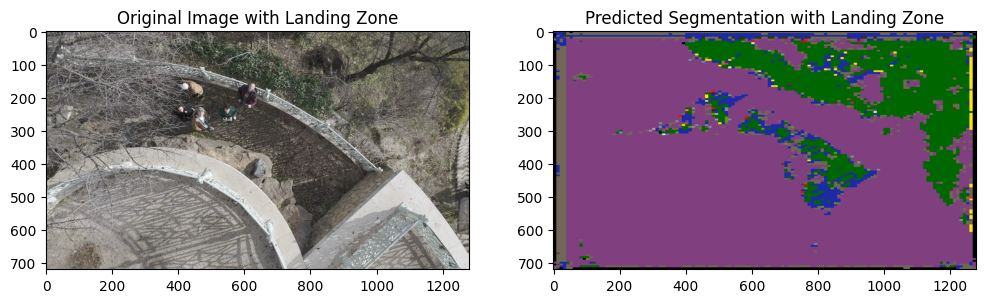

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


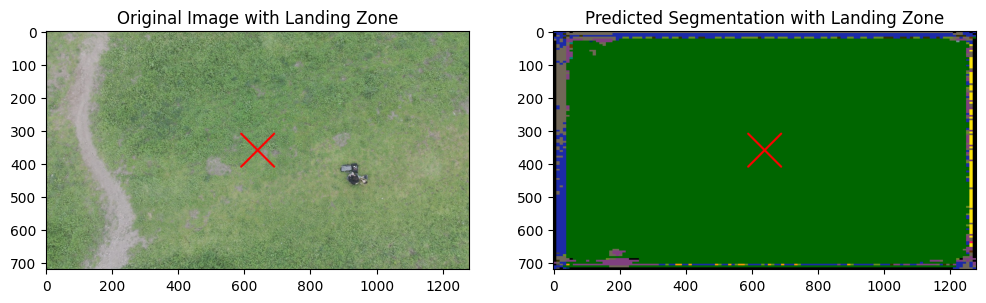

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


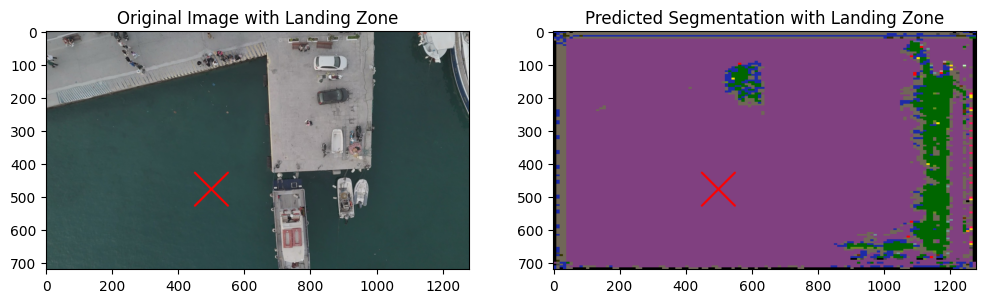

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


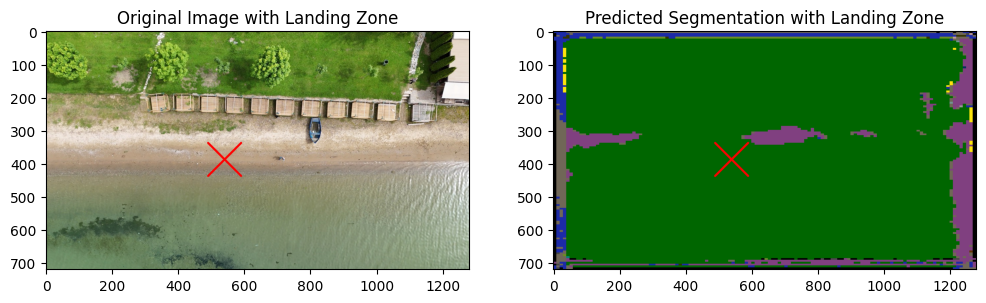

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


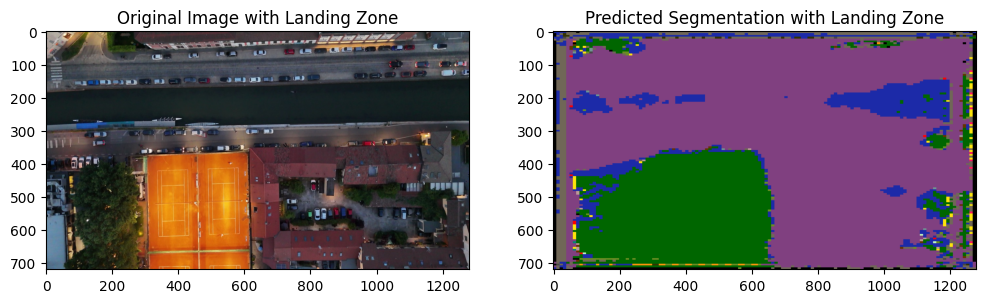

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.measure import label, regionprops

# Load the trained model
model_path = '/kaggle/working/unet_model.keras' 
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient, 'MeanIoU': MeanIoU})

# Constants
IMAGE_SIZE = (128, 128)
REAL_IMAGES_DIR = '/kaggle/input/drone-images/' 

# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, IMAGE_SIZE)
    normalized_image = resized_image / 255.0
    return image, np.expand_dims(normalized_image, axis=0)

# Function to visualize the segmentation mask
def visualize_mask(mask, num_classes):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(num_classes):
        color_mask[mask == i] = label_codes[i]
    return color_mask

# Function to find and draw the landing zone
def find_and_draw_landing_zone(original_img, pred_mask, min_distance_from_obstacles=50):
    # Define safe area and obstacle classes
    safe_area_classes = ['grass', 'paved-area', 'dirt', 'gravel']
    obstacle_classes = ['tree', 'bald-tree', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'ar-marker', 'obstacle', 'conflicting']
    
    safe_area_labels = [label_names.index(cls) for cls in safe_area_classes]
    obstacle_labels = [label_names.index(cls) for cls in obstacle_classes]

    def find_landing_zone(pred_mask):
        safe_mask = np.isin(pred_mask, safe_area_labels).astype(np.uint8)
        obstacle_mask = np.isin(pred_mask, obstacle_labels).astype(np.uint8)
        buffer_zone = cv2.dilate(obstacle_mask, np.ones((min_distance_from_obstacles, min_distance_from_obstacles), np.uint8))
        safe_mask[buffer_zone == 1] = 0
        labeled_mask = label(safe_mask)
        regions = regionprops(labeled_mask)
        if not regions:
            return None, None
        regions = [region for region in regions if region.area >= 1000]
        if not regions:
            return None, None
        largest_region = max(regions, key=lambda region: region.area)
        center_y, center_x = largest_region.centroid
        return int(center_x), int(center_y)

    original_height, original_width = original_img.shape[:2]
    center_x, center_y = find_landing_zone(pred_mask)
    
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    pred_mask_color = visualize_mask(pred_mask_resized, len(label_names))
    
    if center_x is not None and center_y is not None:
        scale_x = original_width / IMAGE_SIZE[1]
        scale_y = original_height / IMAGE_SIZE[0]
        center_x = int(center_x * scale_x)
        center_y = int(center_y * scale_y)
        cv2.line(original_img, (center_x - 50, center_y - 50), (center_x + 50, center_y + 50), (255, 0, 0), 5)
        cv2.line(original_img, (center_x + 50, center_y - 50), (center_x - 50, center_y + 50), (255, 0, 0), 5)
        cv2.line(pred_mask_color, (center_x - 50, center_y - 50), (center_x + 50, center_y + 50), (255, 0, 0), 5)
        cv2.line(pred_mask_color, (center_x + 50, center_y - 50), (center_x - 50, center_y + 50), (255, 0, 0), 5)

    return original_img, pred_mask_color

# Process and predict images
image_paths = [os.path.join(REAL_IMAGES_DIR, img) for img in os.listdir(REAL_IMAGES_DIR) if img.endswith('.jpg')]

for image_path in image_paths:
    original_img, preprocessed_img = preprocess_image(image_path)
    pred_mask = model.predict(preprocessed_img)
    pred_mask = np.argmax(pred_mask[0], axis=-1)
    
    original_img_with_x, pred_mask_with_x = find_and_draw_landing_zone(original_img, pred_mask)
    
    # Plot the original and result images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_with_x)
    plt.title('Original Image with Landing Zone')
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_with_x)
    plt.title('Predicted Segmentation with Landing Zone')
    plt.show()
